<a href="https://colab.research.google.com/github/kumbhat10/Data_Science_in_Python/blob/master/RL_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import libraries**


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import math
import random as rnd
import enum
from IPython.display import clear_output

## **Load Pre trained Q-table**
 
Only if you want to run prediction part without training again

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
 
#np.savetxt('/content/gdrive/My Drive/Colab Notebooks/Sample_data/qTable.csv', qTable, delimiter=',')
qTable = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/Sample_data/qTable.csv', delimiter=',')
qTable_obs = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/Sample_data/qTable_obs.csv', delimiter=',')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Colour class for text outputs**
#### [Colour codes and format](https://ozzmaker.com/add-colour-to-text-in-python/#:~:text=To%20make%20some%20of%20your,right%20into%20the%20print%20statement.)

The ANSI escape code format is;

print("\033[1;32;40m Bright Green  \n")

\033[  Escape code, this is always the same


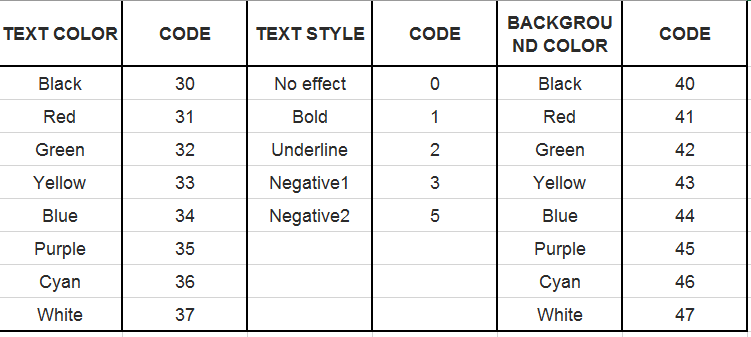

In [ ]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[34m'
    OKGREEN = '\033[32m'
    OKPURPLE = '\033[35m'
    WARNING = '\033[1;31m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

## **Define Environment Class**

In [ ]:
class Environment:
  def __init__(self, size=None, destination=None, startPoint=None, obstacle=None, obstacleSize = None, showPlot=None):
    self.hitMargin = 0
    self.traceActions = []
    self.stepsTaken = 0
    self.reward = 20
    self.penaltyHit = -20
    self.penaltyStep = -1    
    self.penaltyStepDiagonal = -1*math.sqrt(2 * self.penaltyStep**2)
    self.distanceStep = 1
    self.distanceStepDiagonal = math.sqrt(2 * self.distanceStep**2)
    
    self.totatPenalty = 0
    self.totatDistance = 0
    self.obstacleSize = obstacleSize
 
    if size is not None:
     self.env = np.zeros([size[0], size[1]])
    else:
     self.env = np.zeros([30,50])
   
    if destination is not None and destination[0]<= self.env.shape[0]-1 and destination[0]>=0 and destination[1]>=0 and destination[1]<= self.env.shape[1]-1 :
     self.destination = destination
    else:
     print(bcolors.WARNING +"Destination was randomly defined as it was either not defined or out of range\n"+bcolors.ENDC)
     self.destination = (rnd.randint(0,self.env.shape[0]-1), rnd.randint(0,self.env.shape[1]-1))
   
    if startPoint is not None and startPoint[0]<= self.env.shape[0]-1  and startPoint[0]>=0 and startPoint[1]>=0 and startPoint[1]<= self.env.shape[1]-1 :
     self.startPoint = startPoint
    else:
     print(bcolors.WARNING +"StartPoint was randomly defined as it was either not defined or out of range \n"+bcolors.ENDC)
     self.startPoint = (rnd.randint(0,self.env.shape[0]-1), rnd.randint(0,self.env.shape[1]-1))
   
    self.curPosition = self.startPoint
    self.trace = np.array([self.curPosition[0], self.curPosition[1]])   
 
    if obstacle is not None:
      self.obstacle = obstacle
    else:
      self.obstacle = None 

    if showPlot is not None and showPlot:
      self.plotEnvironment()
      if self.obstacle is None:
        plt.title('Environment without Obstacle')
      else:
        plt.title('Environment with Obstacle')

  def getStateFromPosition(self,position=None):   # state number is index number of env array reshaped to Nx1 shape. for eg: for env size of (R,C), given position (r,c) ---> State = c*R + r
    return self.curPosition[1]*self.env.shape[0]  + self.curPosition[0] if position is None else position[1]*self.env.shape[0]  + position[0]
 
  def getPositionFromState(self,state):
    return (state%self.env.shape[0], state//self.env.shape[0])
 
  def resetToInitialEnv(self, resetStartPoint = False):
    if resetStartPoint:
      if self.obstacle is None:
        self.startPoint = (rnd.randint(0,self.env.shape[0]-1), rnd.randint(0,self.env.shape[1]-1))
      else:
        validStartPoint = False
        while not validStartPoint:
          self.startPoint = (rnd.randint(0,self.env.shape[0]-1), rnd.randint(0,self.env.shape[1]-1))
          validStartPoint = (self.startPoint[0] < self.obstacle[0] or self.startPoint[0] > self.obstacle[0]+self.obstacleSize[0] )   and   (self.startPoint[1] < self.obstacle[1] or self.startPoint[1] > self.obstacle[1]+self.obstacleSize[1] )
            
    self.curPosition = self.startPoint
    self.trace = np.array([self.curPosition[0], self.curPosition[1]])
    self.hitMargin = 0
    self.traceActions = []
    self.stepsTaken = 0
    self.totatPenalty = 0
    self.totatDistance = 0
 
  def RandomSearchtoEndPoint(self):
    self.resetToInitialEnv()
    destinationReached = False
 
    while not destinationReached:
      _, penalty, distance, destinationReached = env.step(rnd.choice(list(Action)))
      self.totatPenalty += penalty
      self.totatDistance += distance
    
    self.plotTrace(linewidth = 1.0)
    plt.title('Random actions to reach destination')
    print(f'\n{bcolors.OKBLUE}Steps Taken(Epochs)  : {self.stepsTaken}')
    print(f'{bcolors.WARNING}#of margin hits      : {self.hitMargin}')
    print(f'{bcolors.OKGREEN}Total reward         : {self.totatPenalty:.2f}\n')
 
  def qTableSearchtoEndPoint(self, qTable, startPoint=None, plot = True):
    if startPoint is not None and startPoint[0]<= self.env.shape[0]-1  and startPoint[0]>=0 and startPoint[1]>=0 and startPoint[1]<= self.env.shape[1]-1 :
     self.startPoint = startPoint
     self.resetToInitialEnv(resetStartPoint = False)                    ## Reset the environment - as good as creating new environment with same old destination point
    else:
     print(bcolors.WARNING +"StartPoint was randomly defined as it was either not defined or out of range \n"+bcolors.ENDC)
     self.resetToInitialEnv(resetStartPoint = True)                    ## Reset the environment - as good as creating new environment with same old destination point
         
    destinationReached = False
    while not destinationReached:
      intAction = np.argmax(qTable[self.getStateFromPosition()])  # choose action that has highest q-value for current state number # Exploit learned values   
      _, penalty, distance, destinationReached = self.step(action= list(Action)[intAction])
      self.totatPenalty += penalty
      self.totatDistance += distance
 
    if plot:
      self.plotTrace()
      plt.title('With Q-learning reach destination') 
    print(f"\n{bcolors.WARNING}#of margin hits     : {self.hitMargin}{bcolors.ENDC} \
    \nTotal penalty : {self.totatPenalty:.2f}\
    \npenalty/epoch : {self.totatPenalty/self.stepsTaken:.2f}\
    \n{bcolors.OKPURPLE}Total distance : {self.totatDistance:.2f} \
    \nShortest distance : {self.MinDistanceToCover():.2f}{bcolors.ENDC} \
    \n{bcolors.WARNING}Total epochs : {self.stepsTaken} \
    \nMin epoch : {self.MinEpochBetweenStartandEnd()}{bcolors.ENDC} \
    \nEpoch Ratio : {self.MinEpochBetweenStartandEnd()/self.stepsTaken:.2f}\
    \n{bcolors.OKGREEN}(Closer to 1 Epoch Ratio is most optimized route){bcolors.ENDC}")

  def MinEpochBetweenStartandEnd(self):
    return max(abs(self.startPoint[0]- self.destination[0]), abs(self.startPoint[1]- self.destination[1]) )

  def MinDistanceToCover(self):  ## L + (√2-1)*l where L is max of (Ydelta, Xdelta) and l is min of (YDelta and XDelta)
    return self.MinEpochBetweenStartandEnd() + (math.sqrt(2)-1)*min(abs(self.startPoint[0]- self.destination[0]), abs(self.startPoint[1]- self.destination[1]) )

  def plotEnvironment(self):
    plt.figure(figsize=(10,7))
    plt.scatter(self.destination[1], self.destination[0], c = 'green')
    plt.annotate("End Point",color='green', fontsize = 15, xy =(self.destination[1], self.destination[0]), xytext = (self.destination[1]-2 , -2), arrowprops=dict(facecolor='green', shrink=0)  )
    plt.scatter(self.startPoint[1], self.startPoint[0], c = 'red')
    plt.annotate("Start Point", fontsize = 15, color='red', xy =(self.startPoint[1], self.startPoint[0]), xytext = (self.startPoint[1] - 6,- 2), arrowprops=dict(facecolor='red', shrink=0)  )
    if self.curPosition != self.startPoint:
      plt.scatter(self.curPosition[1], self.curPosition[0], c = 'blue')
      plt.annotate("Current Position", color='blue', fontsize = 15, xy =(self.curPosition[1], self.curPosition[0]), xytext =   (self.curPosition[1] + 3,- 1), arrowprops=dict(facecolor='blue', shrink=0)  )
    plt.xlim(-1, self.env.shape[1])
    plt.ylim(-1, self.env.shape[0])
    plt.gca().invert_yaxis()
    plt.gca().set_yticks(np.arange(0, self.env.shape[0], 1))
    plt.gca().set_xticks(np.arange(0, self.env.shape[1], 1))
    if self.obstacle is not None:                    ### Overlay Obstacle
      plt.gca().add_patch(Rectangle((self.obstacle[1], self.obstacle[0]), self.obstacleSize[1], self.obstacleSize[0], alpha=1, facecolor = 'brown'))
      plt.annotate("Obstacle", color='brown', fontsize = 15, xy =(self.obstacle[1]+ self.obstacleSize[1]/2, self.obstacle[0]+self.obstacleSize[0]/2), xytext = (self.obstacle[1] + 8, self.env.shape[1]+3), arrowprops=dict(facecolor='brown', shrink=0)  )
    plt.grid()
    # plt.show()
    print(f'{bcolors.OKBLUE}End Point is {self.destination}')
    print(f'Start Point is {self.startPoint}{bcolors.ENDC}')
    print(f'{bcolors.OKGREEN}Min Epoch is {self.MinEpochBetweenStartandEnd():.2f}')
    print(f'Min Distance is {self.MinDistanceToCover():.2f}{bcolors.ENDC}')

  def plotTrace(self, linewidth = 3.0):
    self.plotEnvironment()
    plt.plot(self.trace[:,1],self.trace[:,0], color = 'black', linewidth = linewidth) 
 
  def CheckMargins(self,yMin=False, yMax=False , xMin=False, xMax=False):
    yMinCheck = True if not yMin else self.curPosition[0] > 0
    yMaxCheck = True if not yMax else self.curPosition[0] < self.env.shape[0]-1
    xMinCheck = True if not xMin else self.curPosition[1] > 0
    xMaxCheck = True if not xMax else self.curPosition[1] < self.env.shape[1]-1

    return True if yMinCheck and yMaxCheck and xMinCheck and xMaxCheck else False
  
  def CheckObstacleCollision(self, right=False, left=False, top= False, bottom=False):# (y,x) co-ordinates
    checkRight  = True if self.obstacle is None or not right  else \
    self.curPosition[0] > self.obstacle[0]+self.obstacleSize[0]+1 or (self.curPosition[0] == self.obstacle[0]+self.obstacleSize[0]+1 and not top) or \
    self.curPosition[0] < self.obstacle[0]-1 or (self.curPosition[0] == self.obstacle[0]-1 and not bottom) or \
    self.curPosition[1] < self.obstacle[1]-1 or \
    self.curPosition[1] > self.obstacle[1] + self.obstacleSize[1]

    checkLeft   = True if self.obstacle is None or not left   else \
    self.curPosition[0] > self.obstacle[0]+self.obstacleSize[0]+1 or (self.curPosition[0] == self.obstacle[0]+self.obstacleSize[0]+1 and not top) or \
    self.curPosition[0] < self.obstacle[0]-1 or (self.curPosition[0] == self.obstacle[0]-1 and not bottom) or \
    self.curPosition[1] > self.obstacle[1] + self.obstacleSize[1]+1 or \
    self.curPosition[1] < self.obstacle[1]

    checkTop    = True if self.obstacle is None or not top    else self.curPosition[1] > self.obstacle[1]+self.obstacleSize[1] or self.curPosition[1] < self.obstacle[1] or self.curPosition[0] > self.obstacle[0] + self.obstacleSize[0]+1 or self.curPosition[0] < self.obstacle[0]
    checkBottom = True if self.obstacle is None or not bottom else self.curPosition[1] > self.obstacle[1]+self.obstacleSize[1] or self.curPosition[1] < self.obstacle[1] or self.curPosition[0] < self.obstacle[0]-1 or self.curPosition[0] > self.obstacle[0] + self.obstacleSize[0]

    # if not (checkRight and checkLeft and checkTop and checkBottom):
      # print(f'{bcolors.WARNING}Hit Obstacle{bcolors.ENDC}')
    return True if checkRight and checkLeft and checkTop and checkBottom else False
 
  def step(self,action):
    self.stepsTaken += 1
    self.traceActions.append(action) 
 
    if action== Action.TopLeft and self.CheckMargins(yMin= True, xMin = True) and self.CheckObstacleCollision(top=True, left=True): #Top Left Action : TopLeft 
      self.curPosition = (self.curPosition[0]-1, self.curPosition[1]-1 )
      self.trace = np.vstack((self.trace,[self.curPosition[0], self.curPosition[1]]))
      return self.getStateFromPosition(), self.penaltyStepDiagonal if self.curPosition != self.destination else self.reward, self.distanceStepDiagonal, self.curPosition == self.destination
 
    elif action== Action.Top and self.CheckMargins(yMin= True) and self.CheckObstacleCollision(top=True): #Top Left Action : Top 
      self.curPosition = (self.curPosition[0]-1, self.curPosition[1] )
      self.trace = np.vstack((self.trace,[self.curPosition[0], self.curPosition[1]]))
      return self.getStateFromPosition(), self.penaltyStep if self.curPosition != self.destination else self.reward, self.distanceStep, self.curPosition == self.destination
    
    elif action== Action.TopRight and self.CheckMargins(yMin= True, xMax = True) and self.CheckObstacleCollision(top=True, right=True): #Top Right Action :1 
      self.curPosition = (self.curPosition[0]-1, self.curPosition[1]+1 )
      self.trace = np.vstack((self.trace,[self.curPosition[0], self.curPosition[1]]))
      return self.getStateFromPosition(), self.penaltyStepDiagonal if self.curPosition != self.destination else self.reward, self.distanceStepDiagonal, self.curPosition == self.destination
    
    elif action== Action.Left and self.CheckMargins(xMin= True) and self.CheckObstacleCollision(left=True): # Left Action :1 
      self.curPosition = (self.curPosition[0], self.curPosition[1]-1 )
      self.trace = np.vstack((self.trace,[self.curPosition[0], self.curPosition[1]]))
      return self.getStateFromPosition(), self.penaltyStep if self.curPosition != self.destination else self.reward, self.distanceStep, self.curPosition == self.destination
 
    elif action== Action.Right and self.CheckMargins(xMax = True) and self.CheckObstacleCollision(right=True): # Right Action :1 
      self.curPosition = (self.curPosition[0], self.curPosition[1]+1 )
      self.trace = np.vstack((self.trace,[self.curPosition[0], self.curPosition[1]]))
      return self.getStateFromPosition(), self.penaltyStep if self.curPosition != self.destination else self.reward, self.distanceStep, self.curPosition == self.destination
 
    elif action== Action.BottomLeft and self.CheckMargins(yMax= True, xMin = True) and self.CheckObstacleCollision(bottom=True, left=True): #Bottom Left Action :1 
      self.curPosition = (self.curPosition[0]+1, self.curPosition[1]-1 )
      self.trace = np.vstack((self.trace,[self.curPosition[0], self.curPosition[1]]))
      return self.getStateFromPosition(), self.penaltyStepDiagonal if self.curPosition != self.destination else self.reward, self.distanceStepDiagonal, self.curPosition == self.destination
 
    elif action== Action.Bottom and self.CheckMargins(yMax= True) and self.CheckObstacleCollision(bottom=True): #Bottom Action :1 
      self.curPosition = (self.curPosition[0]+1, self.curPosition[1] )
      self.trace = np.vstack((self.trace,[self.curPosition[0], self.curPosition[1]]))
      return self.getStateFromPosition(), self.penaltyStep if self.curPosition != self.destination else self.reward, self.distanceStep, self.curPosition == self.destination
 
    elif action== Action.BottomRight and self.CheckMargins(yMax= True, xMax = True) and self.CheckObstacleCollision(bottom=True, right=True): #Right Action :1 
      self.curPosition = (self.curPosition[0]+1, self.curPosition[1]+1 )
      self.trace = np.vstack((self.trace,[self.curPosition[0], self.curPosition[1]]))
      return self.getStateFromPosition(), self.penaltyStepDiagonal if self.curPosition != self.destination else self.reward, self.distanceStepDiagonal, self.curPosition == self.destination
 
    else: 
      self.hitMargin += 1
      return self.getStateFromPosition(), self.penaltyHit, 0, self.curPosition == self.destination

## **Action Space** - size 8


### We can take any of the below 8 actions 

In [ ]:
class Action(enum.Enum):
 
  TopLeft = (-1,-1)
  Top     = (-1,0)
  TopRight= (-1,1)
  Left    = (0,-1)
  Right   = (0,1)
  BottomLeft = (1,-1)
  Bottom = (1,0)
  BottomRight = (1,1)

## **State Space** - size 900

For an environment of size 30x30,  we have 900 possible locations where our car can be.

To simplify learning, we will define ony **1 destination points**.

With more destination points, the size of state space will also increase

So, total no.of state space = 30 x 30 x 1 = **900** possible states

We also need to assign a **unique identifier** to each state (number based indexing would be much simpler) 

## **Creating Environment**

Size attribute of environment defines the space layout (rows,cols)

startPoint and endPoint can also be defined else environment will randomly define it

obstacle = co-ordinate of top left corner of obstacle to insert

obstacleSize = (y,x) grid size 

For our problem, we will fix the destination point right now.

# **Q-learning without obstacle**

## **Create Environment without obstacle**

End Point is (28, 22)
Start Point is (5, 12)
Min Epoch is 23.00
Min Distance is 27.14


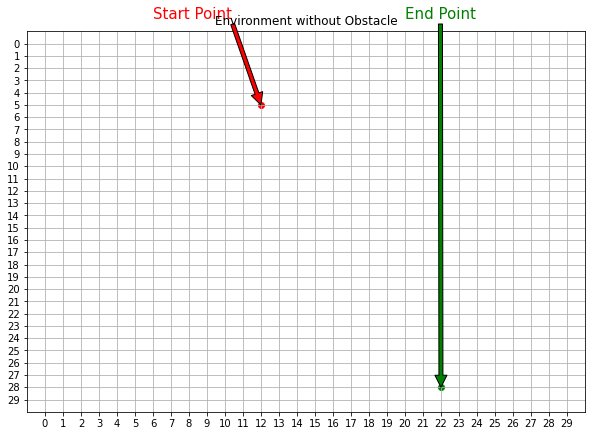

In [ ]:
env = Environment(size=(30,30), startPoint=(5,12), destination = (28,22), showPlot=True)

## **Random search algorithm**

Choose random actions to reach Endpoint from start point

The Environment.RandomSearchtoEndPoint() method takes random actions in a loop starting from startPoint until it reaches EndPoint

End Point is (28, 22)
Start Point is (5, 12)
Min Epoch is 23.00
Min Distance is 27.14

Steps Taken(Epochs)  : 1974
#of margin hits      : 92
Total reward         : -4084.15



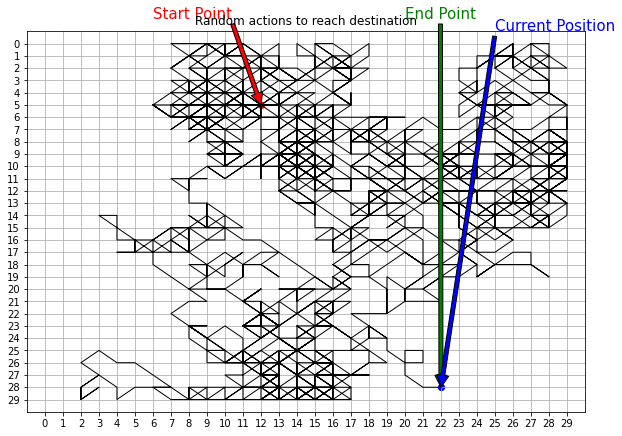

In [ ]:
env.RandomSearchtoEndPoint()

## **Defining Reward and Penalty**

Reaching Destination(End Point)  = +20 Points (Reward)
 
Every Action/Step taken (NEWS*)          = -1 Points (Penalty)
 
Every Action/Step taken diagonally.                  = -sqrt(2) Points (Penalty) 

Hiting border/margin             = -10 Points (Penalty)

*NEWS - North East West south

## **Agent**

### **Intro to Q-learning**

Essentially, **Q-learning** lets the agent use the environment's rewards to learn, over time, the best action to take in a given state.

In our environment, the agent will learn by **looking for received reward** for taking an action in the current state, then **updating a Q-value** to remember if that action was beneficial.

The values store in the Q-table are called **Q-values**, and they map to a **(state, action)** combination.

A Q-value for a particular state-action combination is representative of the **"quality"** of an action taken from that state. 

**Better Q-values imply better chances of getting greater rewards**

## **Q(state,action)← (1−α)Q(state,action)  +  α(reward + γmaxaQ(next state,all actions))**

Where:

- **α (alpha)** is the learning rate (0<α≤1) - Just like in supervised learning settings, α is the extent to which our Q-values are being updated in every iteration.

- **γ (gamma)** is the discount factor (0≤γ≤1) - determines how much importance we want to give to future rewards. 

A high value for the **discount factor** (close to 1) captures the **long-term effective award**, whereas, 

a **discount factor of 0** makes our agent consider only immediate reward, hence making it **greedy**


**What is this saying?**

We are assigning (←), or updating, the Q-value of the agent's current state and action by first taking a **weight (1−α) of the old Q-value**, then adding the learned value. 

The **learned value** is a combination of the reward for **taking the current action** in the current state, and the **discounted maximum reward from the next state** we will be in once we take the current action.

Basically, we are learning the proper action to take in the current state by looking at the reward for the **current state/action combo**, and the **max rewards for the next state**

## **The Q-Table**
 
Its a matrix of size **SxA** ehere S is number of **States** in our problem and A is number of **Actions** we have.
 
It's first initialized to 0, and then values are updated after training

In [ ]:
qTable = np.zeros([env.env.size, len(Action)])
qTable
# env.qTable[list(Action)[2]][5] indexing 6th row 3rd col

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### **Exploiting learned values**

After enough random exploration of actions, the **Q-values tend to converge** serving our agent as an action-value function which it can exploit to pick the most optimal action from a given state.

There's a tradeoff between **exploration (choosing a random action)** and **exploitation (choosing actions based on already learned Q-values)**. We want to prevent the action from always taking the same route, and possibly overfitting, 

So, Introducing another parameter called **ϵ "epsilon"** to cater to this during training.

Instead of just selecting the best learned Q-value action, we'll sometimes favor exploring the action space further.

**Lower epsilon** value results in **episodes with more penalties** (on average) which is obvious because we are exploring and making random decisions

## **Training the Agent**

can be skipped if directly loading qTable from drive

In [ ]:
# Hyperparameters
alpha = 0.8   #0.1 # α (alpha) is the learning rate (0<α≤1) - Just like in supervised learning settings, α is the extent to which our Q-values are being updated in every iteration.
gamma = 0.9    #0.6 # γ (gamma) is the discount factor (0≤γ≤1) - determines how much importance we want to give to future rewards.
epsilon = 0.9     # 0.1 values means 10% exploiatation of learned values and 
                                  #  90% exploring randomly in action space
# For plotting metrics
allEpochs = []
allPenalties = []
allMinEpochs = []
nEpisodes = 500000

for i in range(1,nEpisodes+1):
  env.resetToInitialEnv(resetStartPoint= True)                    ## Reset the environment - as good as creating new environment with same old destination point
  currentState = env.getStateFromPosition()  ## gives state for current postion
  epochs, penalties, reward = 0,0,0
  destinationReached = False

  while not destinationReached:
    if rnd.uniform(0,1) > epsilon:
      intAction = rnd.choice(range(len(Action))) # Explore action space - choose random action
    else:
      intAction = np.argmax(qTable[env.getStateFromPosition()])  # choose action that has highest q-value for current state number # Exploit learned values  
    
    nextState, reward, destinationReached = env.step(action= list(Action)[intAction])
    penalties += reward
    qValueOld = qTable[currentState, intAction]
    qMaxNextState   = np.max(qTable[nextState])

    qValueNew = (1 - alpha)*qValueOld   +  alpha*(reward + gamma*qMaxNextState)
    qTable[currentState, intAction] = qValueNew
    currentState = nextState

  minEpoch = max(abs(env.startPoint[0]- env.destination[0]), abs(env.startPoint[1]- env.destination[1]) )
  allPenalties.append(penalties)
  allEpochs.append(env.stepsTaken)
  allMinEpochs.append(minEpoch)

  if i % 500 == 0:
    # epsilon = min(1, max(0.2, i/5000*0.2))
    clear_output(wait=True)
    print(f"Episode # : {i} \
    \nTotal penalty : {penalties:.2f}\
    \npenalty/epoch : {penalties/env.stepsTaken:.2f} \
    \nTotal epochs : {env.stepsTaken} \
    \nMin Epoch : {minEpoch} \
    \nEpoch Ratio : {minEpoch/env.stepsTaken:.2f}\
    \n(Closer to 1 Epoch Ratio is most optimized way)")

Episode # : 500000 
Total penalty : 13.17157287525381
penalty/epoch : 1.8816532678934015 
Total epochs : 7 
Min Epoch : 5 
Epoch Ratio : 0.7142857142857143
(Closer to 1 Epoch Ratio is most optimized way)


In [ ]:
result = [i / j for i, j in zip(allMinEpochs, all_epochs)] 
plt.plot(result)

## **Save Q-table**

Required only if re-training and want to save new qTable

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
 
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/Sample_data/qTable.csv', qTable, delimiter=',')
#qTable = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/Sample_data/qTable.csv', delimiter=',')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Use trained Q-table for way points prediction

#### Let's see output of our model for different start points and same endpoint

### **Test Example 1**

StartPoint was randomly defined as it was either not defined or out of range 

End Point is (28, 22)
Start Point is (10, 7)
Min Epoch is 18.00
Min Distance is 24.21

#of margin hits     : 0     
Total penalty : -2.80    
penalty/epoch : -0.16    
Total distance : 24.21     
Shortest distance : 24.21     
Total epochs : 18     
Min epoch : 18     
Epoch Ratio : 1.00    
(Closer to 1 Epoch Ratio is most optimized route)


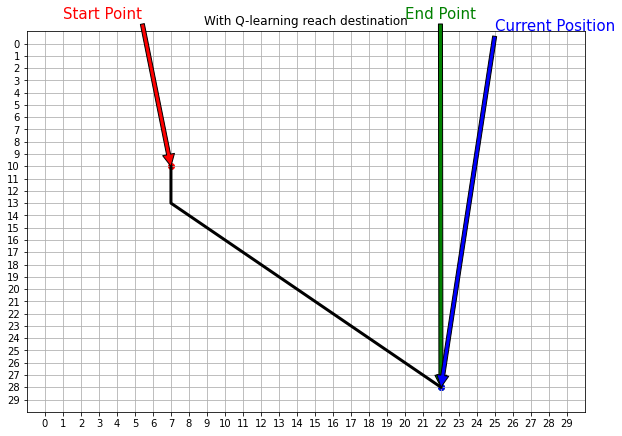

In [ ]:
envTest = Environment(size=(30,30), destination = (28,22) ,showPlot=False) 
envTest.qTableSearchtoEndPoint(qTable=qTable, startPoint=(10,7))

The predicted way point is one of the shortest path to destination point

### **Test example 2**

End Point is (28, 22)
Start Point is (5, 28)
Min Epoch is 23.00
Min Distance is 25.49

#of margin hits     : 0     
Total penalty : -4.07    
penalty/epoch : -0.18    
Total distance : 25.49     
Shortest distance : 25.49     
Total epochs : 23     
Min epoch : 23     
Epoch Ratio : 1.00    
(Closer to 1 Epoch Ratio is most optimized route)


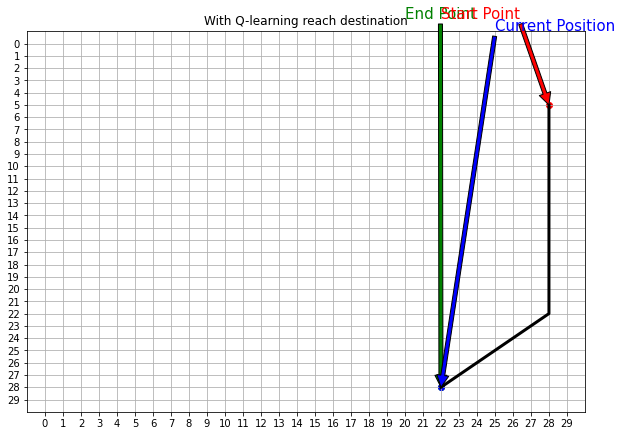

In [ ]:
 envTest.qTableSearchtoEndPoint(qTable=qTable, startPoint=(5,28))

### **Test Example 3**

End Point is (28, 22)
Start Point is (0, 0)
Min Epoch is 28.00
Min Distance is 37.11

#of margin hits     : 0     
Total penalty : -15.70    
penalty/epoch : -0.56    
Total distance : 37.11     
Shortest distance : 37.11     
Total epochs : 28     
Min epoch : 28     
Epoch Ratio : 1.00    
(Closer to 1 Epoch Ratio is most optimized route)


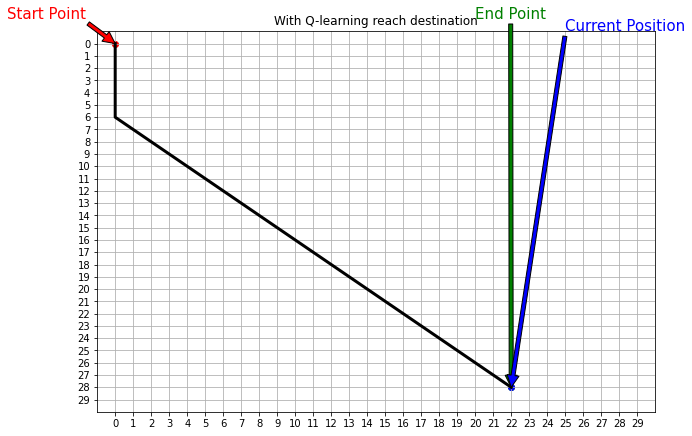

In [ ]:
 envTest.qTableSearchtoEndPoint(qTable=qTable, startPoint=(0,0))

### **Test Example 4**

End Point is (28, 22)
Start Point is (22, 1)
Min Epoch is 21.00
Min Distance is 23.49

#of margin hits     : 0     
Total penalty : -2.07    
penalty/epoch : -0.10    
Total distance : 23.49     
Shortest distance : 23.49     
Total epochs : 21     
Min epoch : 21     
Epoch Ratio : 1.00    
(Closer to 1 Epoch Ratio is most optimized route)


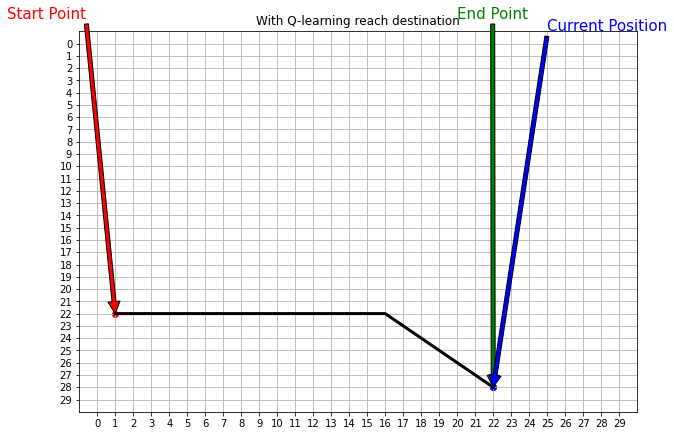

In [ ]:
 envTest.qTableSearchtoEndPoint(qTable=qTable, startPoint=(22,1)) # 26,2

### **Test for Shortest distance from all different start positions**

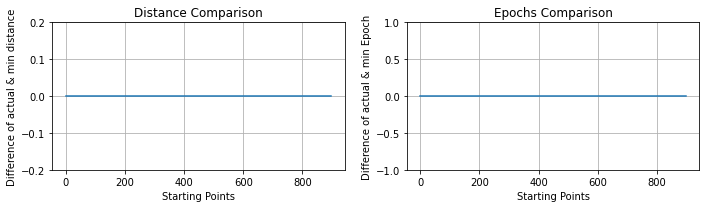

In [ ]:
envTest = Environment(size=(30,30), destination = (28,22) ,showPlot=False) 
allEpochs = []
allMinEpochs = []
allDistance = []
allMinDistance = []

for iY in range(envTest.env.shape[0]):
  for iX in range(envTest.env.shape[0]):
    if envTest.destination != (iY, iX):
      envTest.qTableSearchtoEndPoint(qTable=qTable, startPoint=(iY, iX), plot= False)
      allEpochs.append(envTest.stepsTaken)
      allMinEpochs.append(envTest.MinEpochBetweenStartandEnd())
      allDistance.append(envTest.totatDistance)
      allMinDistance.append(envTest.MinDistanceToCover())
      clear_output(wait= True)

diffDistance = [i-j for i, j in zip(allDistance, allMinDistance)]
diffEpochs = [i-j for i, j in zip(allEpochs, allMinEpochs)]

# plt.subplots(1,2)
fig = plt.figure(figsize=(10,3))
plt.subplot(1,2, 1)
plt.plot(diffDistance)
plt.ylim(-0.2,0.2)
plt.ylabel('Difference of actual & min distance')
plt.xlabel('Starting Points')
plt.title('Distance Comparison')
plt.grid()

plt.subplot(1,2, 2)
plt.plot(diffEpochs)
plt.ylim(-1,1)
plt.ylabel('Difference of actual & min Epoch')
plt.xlabel('Starting Points')
plt.title('Epochs Comparison')
plt.grid()
fig.tight_layout()
plt.show()

### Above figure suggests our model has learnt the q-values to reach destination with **minimum epochs** as well as **minimum distance** with **maximum reward**


# **Q-Learning with obstacle**

End Point is (28, 22)
Start Point is (9, 4)
Min Epoch is 19.00
Min Distance is 26.46


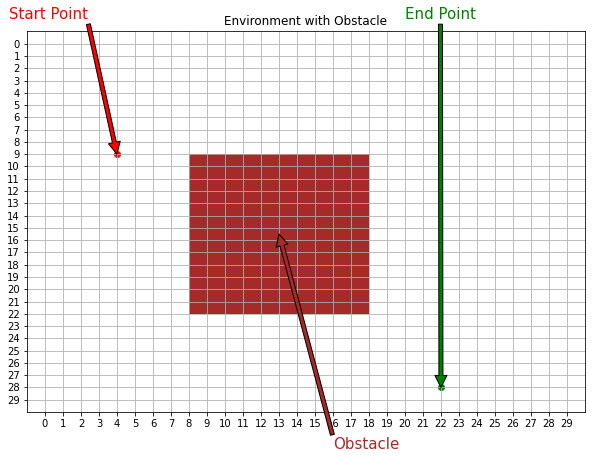

In [ ]:
env = Environment(size=(30,30), startPoint=(9,4), destination = (28,22), obstacle=(9,8), obstacleSize=(13,10), showPlot=True)

## **Random search algorithm**

Choose random actions to reach Endpoint from start point

End Point is (28, 22)
Start Point is (9, 4)
Min Epoch is 19.00
Min Distance is 26.46

Steps Taken(Epochs)  : 1695
#of margin hits      : 130
Total reward         : -4455.07



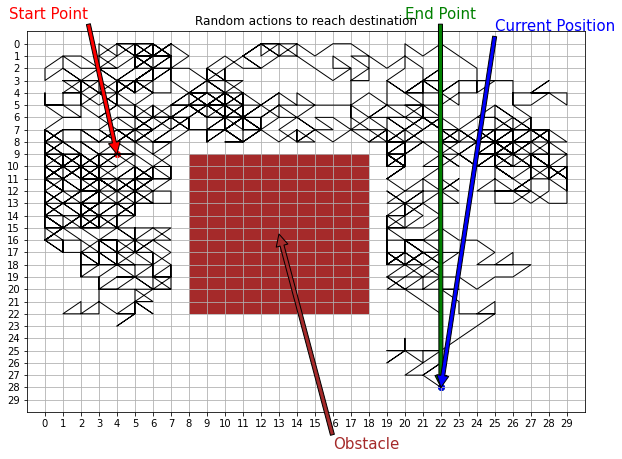

In [ ]:
env = Environment(size=(30,30), startPoint=(9,4), destination = (28,22), obstacle=(9,8), obstacleSize=(13,10), showPlot=False)
env.RandomSearchtoEndPoint()

## **The Q-Table**
 
Its a matrix of size **SxA** ehere S is number of **States** in our problem and A is number of **Actions** we have.
 
It's first initialized to 0, and then values are updated after training

In [ ]:
qTable_obs = np.zeros([env.env.size, len(Action)])
# env.qTable[list(Action)[2]][5] indexing 6th row 3rd col

## **Load Pre trained Q-table**
 
Only if you want to run prediction part without training again

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
 
#np.savetxt('/content/gdrive/My Drive/Colab Notebooks/Sample_data/qTable.csv', qTable, delimiter=',')
qTable_obs = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/Sample_data/qTable_obs.csv', delimiter=',')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Training the Agent**

can be skipped if directly loading qTable from drive

In [ ]:
# Hyperparameters
alpha = 0.98   #0.1 # α (alpha) is the learning rate (0<α≤1) - Just like in supervised learning settings, α is the extent to which our Q-values are being updated in every iteration.
gamma = 0.99    #0.6 # γ (gamma) is the discount factor (0≤γ≤1) - determines how much importance we want to give to future rewards.
epsilon = 0.9     # 0.1 values means 10% exploiatation of learned values and 
                                  #  90% exploring randomly in action space
# For plotting metrics
allEpochs = []
allPenalties = []
allMinEpochs = []
nEpisodes = 500000

for i in range(1,nEpisodes+1):
  env.resetToInitialEnv(resetStartPoint= True)                    ## Reset the environment - as good as creating new environment with same old destination point
  currentState = env.getStateFromPosition()  ## gives state for current postion
  epochs, penalties, reward = 0,0,0
  destinationReached = False

  while not destinationReached:
    if rnd.uniform(0,1) > epsilon:
      intAction = rnd.choice(range(len(Action))) # Explore action space - choose random action
    else:
      intAction = np.argmax(qTable_obs[env.getStateFromPosition()])  # choose action that has highest q-value for current state number # Exploit learned values  
    
    nextState, reward, _, destinationReached = env.step(action= list(Action)[intAction])
    penalties += reward
    qValueOld = qTable_obs[currentState, intAction]
    qMaxNextState   = np.max(qTable_obs[nextState])

    qValueNew = (1 - alpha)*qValueOld   +  alpha*(reward + gamma*qMaxNextState)
    qTable_obs[currentState, intAction] = qValueNew
    currentState = nextState

  minEpoch = max(abs(env.startPoint[0]- env.destination[0]), abs(env.startPoint[1]- env.destination[1]) )
  allPenalties.append(penalties)
  allEpochs.append(env.stepsTaken)
  allMinEpochs.append(minEpoch)

  if i % 500 == 0:
    # epsilon = min(1, max(0.2, i/5000*0.2))
    clear_output(wait=True)
    print(f"Episode # : {i} \
    \nTotal penalty : {penalties:.2f}\
    \npenalty/epoch : {penalties/env.stepsTaken:.2f} \
    \nTotal epochs : {env.stepsTaken} \
    \nMin Epoch : {minEpoch} \
    \nEpoch Ratio : {minEpoch/env.stepsTaken:.2f}\
    \n(Closer to 1 Epoch Ratio is most optimized way)")

Episode # : 96500     
Total penalty : -7.66    
penalty/epoch : -0.28     
Total epochs : 27     
Min Epoch : 25     
Epoch Ratio : 0.93    
(Closer to 1 Epoch Ratio is most optimized way)


KeyboardInterrupt: ignored

## **Save Q-table**

Required only if re-training and want to save new qTable

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
 
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/Sample_data/qTable_obs.csv', qTable, delimiter=',')
#qTable = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/Sample_data/qTable.csv', delimiter=',')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Use trained Q-table for way points prediction

#### Let's see output of our model for different start points and same endpoint

### **Test Example 1**

End Point is (28, 22)
Start Point is (9, 4)
Min Epoch is 19.00
Min Distance is 26.46

#of margin hits     : 0     
Total penalty : -10.90    
penalty/epoch : -0.38    
Total distance : 32.31     
Shortest distance : 26.46     
Total epochs : 29     
Min epoch : 19     
Epoch Ratio : 0.66    
(Closer to 1 Epoch Ratio is most optimized route)


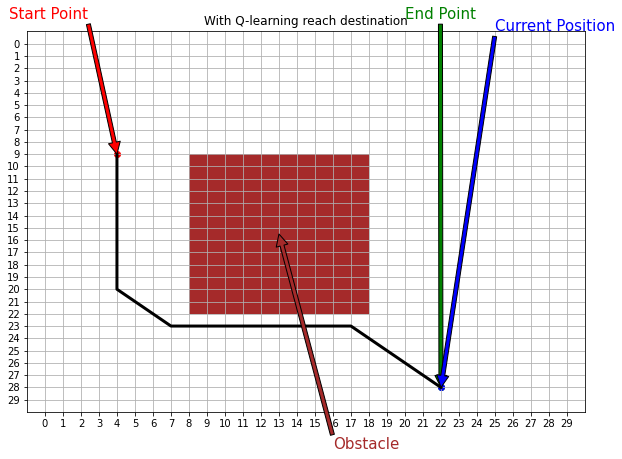

In [ ]:
envTest = Environment(size=(30,30), startPoint=(9,4), destination = (28,22), obstacle=(9,8), obstacleSize=(13,10), showPlot=False)
envTest.qTableSearchtoEndPoint(qTable=qTable_obs, startPoint=(9,4))

### **Test Example 2**

End Point is (28, 22)
Start Point is (4, 8)
Min Epoch is 24.00
Min Distance is 29.80

#of margin hits     : 0     
Total penalty : -15.07    
penalty/epoch : -0.44    
Total distance : 36.49     
Shortest distance : 29.80     
Total epochs : 34     
Min epoch : 24     
Epoch Ratio : 0.71    
(Closer to 1 Epoch Ratio is most optimized route)


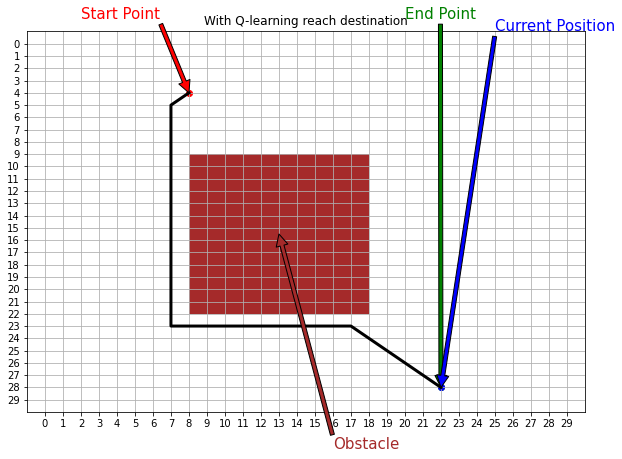

In [ ]:
envTest.qTableSearchtoEndPoint(qTable=qTable_obs, startPoint=(4,8))

End Point is (28, 22)
Start Point is (0, 0)
Min Epoch is 28.00
Min Distance is 37.11

#of margin hits     : 0     
Total penalty : -21.56    
penalty/epoch : -0.57    
Total distance : 42.97     
Shortest distance : 37.11     
Total epochs : 38     
Min epoch : 28     
Epoch Ratio : 0.74    
(Closer to 1 Epoch Ratio is most optimized route)


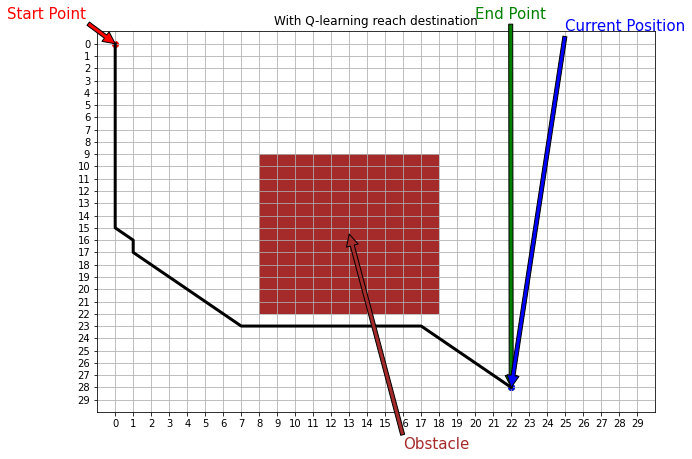

In [ ]:
envTest.qTableSearchtoEndPoint(qTable=qTable_obs, startPoint=(0,0))

End Point is (28, 22)
Start Point is (1, 9)
Min Epoch is 27.00
Min Distance is 32.38

#of margin hits     : 0     
Total penalty : -19.90    
penalty/epoch : -0.52    
Total distance : 41.31     
Shortest distance : 32.38     
Total epochs : 38     
Min epoch : 27     
Epoch Ratio : 0.71    
(Closer to 1 Epoch Ratio is most optimized route)


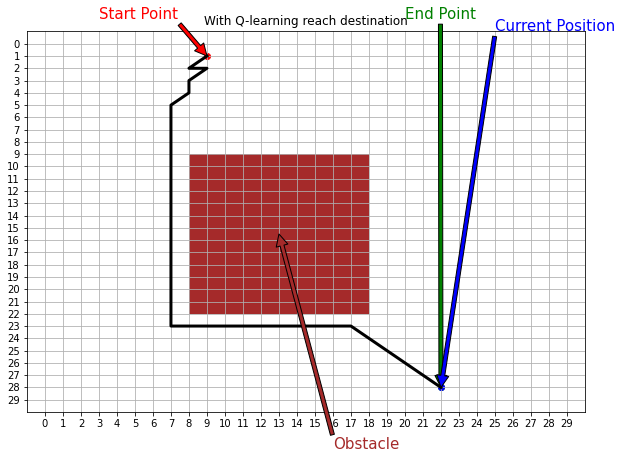

In [ ]:
envTest.qTableSearchtoEndPoint(qTable=qTable_obs, startPoint=(1,9))